In [503]:
import time
import pandas as pd
from sklearn import preprocessing
from sklearn.model_selection import KFold
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix
import tensorflow.keras as keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras import regularizers
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ReduceLROnPlateau,EarlyStopping,ModelCheckpoint,LearningRateScheduler
SEED = 42

import os
os.environ['TF_CUDNN_DETERMINISTIC'] = '1'

import random 
random.seed(SEED)

import numpy as np
from numpy import loadtxt
np.random.seed(SEED)

import tensorflow as tf
tf.random.set_seed(SEED)

## LSTM-A

In [504]:
#import the train and test files for financial news
fnews_Xtrain = loadtxt('data/train/fnews_Xtrain_.csv', delimiter=',')
fnews_Xtest = loadtxt('data/test/fnews_Xtest_.csv', delimiter=',')
fnews_ytrain = loadtxt('data/train/fnews_ytrain_.csv',delimiter=',')
fnews_ytest = loadtxt('data/test/fnews_ytest_.csv',delimiter=',')

In [505]:
#convert to array of integers from full precision
fnews_Xtrain=fnews_Xtrain.astype(int)
fnews_Xtest=fnews_Xtest.astype(int)
fnews_ytrain=fnews_ytrain.astype(int)
fnews_ytest=fnews_ytest.astype(int)

In [506]:
#import the weights
fnews_weights = loadtxt('data/weights/weights_fnews_.csv', delimiter=',')
squidgame_weights = loadtxt('data/weights/weights_squidgame_.csv', delimiter=',')

In [507]:
#check the respective shape of the train and test sets
print('Xtrain:',fnews_Xtrain.shape, 'ytrain:' ,fnews_ytrain.shape)
print('Xtest:',fnews_Xtest.shape, 'ytest:' ,fnews_ytest.shape)

Xtrain: (3876, 38) ytrain: (3876, 3)
Xtest: (970, 38) ytest: (970, 3)


In [508]:
fnews_weights.shape

(9243, 100)

In [527]:
#using the word2vec 

def LSTM_Model():
    
    
    model = Sequential()
    
    model.add(Embedding(fnews_weights.shape[0],fnews_weights.shape[1], weights = [fnews_weights],
                       input_length = 38))
    #for regularisation (batch norm)
    model.add(BatchNormalization()) 
    #for regularisation (drop outs)
    model.add(Bidirectional(LSTM(38, recurrent_dropout = 0.4)))
    model.add(Dense(3, activation='softmax'))
    model.compile(optimizer = tf.keras.optimizers.SGD(learning_rate = 0.01),loss="categorical_crossentropy",metrics= [tf.keras.metrics.CategoricalAccuracy('accuracy'), tf.keras.metrics.Precision(name='precision'), tf.keras.metrics.Recall(name='recall'), 'acc'])
    
    return model

model = LSTM_Model()
model.summary()

Model: "sequential_103"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_100 (Embedding)   (None, 38, 100)           924300    
                                                                 
 batch_normalization_82 (Bat  (None, 38, 100)          400       
 chNormalization)                                                
                                                                 
 bidirectional_86 (Bidirecti  (None, 76)               42256     
 onal)                                                           
                                                                 
 dense_85 (Dense)            (None, 3)                 231       
                                                                 
Total params: 967,187
Trainable params: 966,987
Non-trainable params: 200
_________________________________________________________________


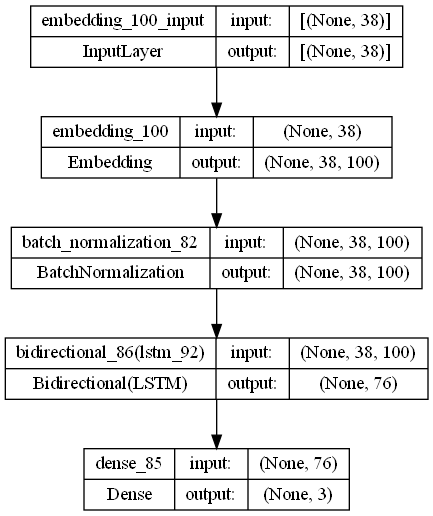

In [528]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [529]:
# set callbacks to ensure model does not overfit. Ensures training of network is stopped when 
# the validation error starts increasing
early_stop = tf.keras.callbacks.EarlyStopping(monitor = "loss", patience = 3)

In [530]:
start = time.time()
model= LSTM_Model()
history = model.fit(
    fnews_Xtrain, 
    fnews_ytrain, 
    epochs = 30,
    batch_size = 64,
    validation_data = (fnews_Xtest, fnews_ytest),
    verbose = 1,
    callbacks = early_stop,
)
end = time.time()

Epoch 1/30
61/61 [==============================] - 34s 319ms/step - loss: 1.0334 - accuracy: 0.4791 - precision: 0.5255 - recall: 0.2178 - acc: 0.4791 - val_loss: 0.9615 - val_accuracy: 0.5887 - val_precision: 0.6021 - val_recall: 0.4072 - val_acc: 0.5887
Epoch 2/30
61/61 [==============================] - 8s 127ms/step - loss: 0.9404 - accuracy: 0.5906 - precision: 0.6074 - recall: 0.5101 - acc: 0.5906 - val_loss: 0.9296 - val_accuracy: 0.5887 - val_precision: 0.6131 - val_recall: 0.4918 - val_acc: 0.5887
Epoch 3/30
61/61 [==============================] - 8s 127ms/step - loss: 0.9185 - accuracy: 0.5949 - precision: 0.6317 - recall: 0.5382 - acc: 0.5949 - val_loss: 0.9104 - val_accuracy: 0.5928 - val_precision: 0.6341 - val_recall: 0.5216 - val_acc: 0.5928
Epoch 4/30
61/61 [==============================] - 7s 118ms/step - loss: 0.9029 - accuracy: 0.6045 - precision: 0.6416 - recall: 0.5482 - acc: 0.6045 - val_loss: 0.8955 - val_accuracy: 0.6113 - val_precision: 0.6517 - val_recall: 

time taken: 227.37884759902954


Text(0.5, 0, 'Number of Epochs')

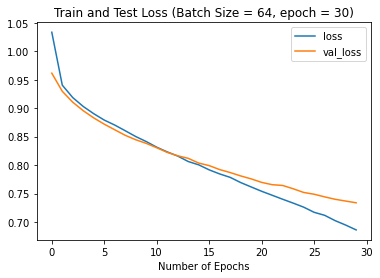

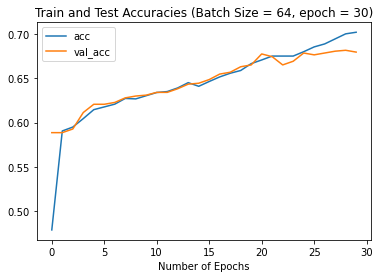

In [532]:
#plot the train and test accuracies

print('time taken:', end-start)

metrics_df_1 = pd.DataFrame(history.history)
ax = metrics_df_1[["loss", "val_loss"]].plot()
ax.set_title("Train and Test Loss (Batch Size = 64, epoch = 30)")
ax.set_xlabel("Number of Epochs")
ax1 = metrics_df_1[["acc", "val_acc"]].plot()
ax1.set_title("Train and Test Accuracies (Batch Size = 64, epoch = 30)")
ax1.set_xlabel("Number of Epochs")

In [ ]:
# #tune the hyper parameters by using KFold Validation (batch size)

# no_of_fold = 5
# batch_size = [16, 32, 64, 128, 512]
# kf = KFold(n_splits = no_of_fold)


# def train_exp(df):
#     results = pd.DataFrame(columns = ["Fold Number", "Batch Size",
#                                       "Cross Validation Accuracy", "Time Taken"])
#     acc = []
#     fold_no = 1
#     for train, test in kf.split(df):
#         X_train, y_train, X_test, y_test = split_dataset(df, columns_to_drop, test_size=0.2, random_state=0) 
#         X_train_scaled, X_test_scaled = preprocess_dataset(X_train, X_test)
#         acc_ = []
#         print('------------------------------------------------------------------------')
#         print(f'Training for fold {fold_no} ...')
#         for batch in batch_size:
#             print(f'Training for batch size {batch}')
#             start = time.time()
#             history = DNN_network.fit(X_train_scaled, y_train, 
#                         validation_data=(X_test_scaled, y_test), 
#                         epochs = 100 , callbacks = [early_stop,csv_logger], batch_size = batch)
#             end = time.time()
#             time_taken =  end - start
#             acc_.append(min(history.history['val_binary_accuracy']))
#             val_acc = min(history.history['val_binary_accuracy'])
#             #add results to dataframe
#             insert_row = {'Fold Number': fold_no, 'Batch Size':batch, 
#                           'Cross Validation Accuracy': val_acc, 
#                           'Time Taken': time_taken}
#             results = pd.concat([results, pd.DataFrame([insert_row])])
#         fold_no = fold_no + 1
#         acc.append(acc_)
#     acc_err = np.mean(np.array(acc), axis = 0)
#     return results, acc_err

In [ ]:
#create the LSTM Model
## LSTM is an artificial recurrent neural network architecture and instead of standard feedforward neural network,
## LSTM has feedback connections (signals traveling in both areas)

#from preprocessing
vocab_length = 9243

model1 = Sequential()
#first embedding layer converts each word into a fixed-length vector of defined size
model1.add(Embedding(vocab_length, 32, input_length = fnews_Xtrain.shape[1]))
#prevent overfitting with Dropout which is a type of dropout for convolutional networks
model1.add(Conv1D(filters=64, kernel_size=3, padding='same', activation='relu'))
model1.add(MaxPooling1D(pool_size=2))
#for regularisation
model1.add(BatchNormalization()) 

model1.add(Bidirectional(LSTM(32, recurrent_dropout = 0.5)))
model1.add(Dense(3,activation="softmax"))

In [412]:
# output model skeleton
## batch size of 32, epochs = 50 and learning rate of 0.1 (step based decay rate)
batch_size = 32
learning_rate = 0.1
epochs = 50
model1.summary()
model1.compile(optimizer = tf.keras.optimizers.SGD(learning_rate = learning_rate, decay=learning_rate/epochs),loss="categorical_crossentropy",metrics=['acc'])

Model: "sequential_65"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_62 (Embedding)    (None, 38, 32)            295776    
                                                                 
 conv1d_70 (Conv1D)          (None, 38, 64)            6208      
                                                                 
 max_pooling1d_58 (MaxPoolin  (None, 19, 64)           0         
 g1D)                                                            
                                                                 
 batch_normalization_46 (Bat  (None, 19, 64)           256       
 chNormalization)                                                
                                                                 
 bidirectional_48 (Bidirecti  (None, 64)               24832     
 onal)                                                           
                                                     

If the loss increases and the accuracy increase too is because your regularization techniques are working well and you're fighting the overfitting problem. This is true only if the loss, then, starts to decrease whilst the accuracy continues to increase. Otherwise, if the loss keep growing your model is diverging and you should look for the cause (usually you're using a too high learning rate value).

# LSTM-B

In [392]:
#import the train and test files for financial news
squidgame_Xtrain = loadtxt('data/train/squidgame_Xtrain_.csv', delimiter=',')
squidgame_Xtest = loadtxt('data/test/squidgame_Xtest_.csv', delimiter=',')
squidgame_ytrain = loadtxt('data/train/squidgame_ytrain_.csv',delimiter=',')
squidgame_ytest = loadtxt('data/test/squidgame_ytest_.csv',delimiter=',')

In [393]:
#convert to array of integers from full precision
squidgame_Xtrain=squidgame_Xtrain.astype(int)
squidgame_Xtest=squidgame_Xtest.astype(int)
squidgame_ytrain=squidgame_ytrain.astype(int)
squidgame_ytest=squidgame_ytest.astype(int)

In [394]:
#check the respective shape of the train and test sets
print('Xtrain:',squidgame_Xtrain.shape, 'ytrain:' ,squidgame_ytrain.shape)
print('Xtest:',squidgame_Xtest.shape, 'ytest:' ,squidgame_ytest.shape)

Xtrain: (948, 831) ytrain: (948, 3)
Xtest: (237, 831) ytest: (237, 3)


In [537]:
#using the word2vec 

def LSTM_Model_2():
    
    
    model = Sequential()
    
    model.add(Embedding(fnews_weights.shape[0],fnews_weights.shape[1], weights = [fnews_weights],
                       input_length = 831))
    #for regularisation (batch norm)
    model.add(BatchNormalization()) 
    #for regularisation (drop outs)
    model.add(Bidirectional(LSTM(831, recurrent_dropout = 0.4)))
    model.add(Dense(3, activation='softmax'))
    model.compile(optimizer = tf.keras.optimizers.SGD(learning_rate = 0.01),loss="categorical_crossentropy",metrics= [tf.keras.metrics.CategoricalAccuracy('accuracy'), tf.keras.metrics.Precision(name='precision'), tf.keras.metrics.Recall(name='recall'), 'acc'])
    
    return model

model = LSTM_Model_2()
model.summary()

Model: "sequential_109"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_106 (Embedding)   (None, 831, 100)          924300    
                                                                 
 batch_normalization_88 (Bat  (None, 831, 100)         400       
 chNormalization)                                                
                                                                 
 bidirectional_92 (Bidirecti  (None, 1662)             6195936   
 onal)                                                           
                                                                 
 dense_91 (Dense)            (None, 3)                 4989      
                                                                 
Total params: 7,125,625
Trainable params: 7,125,425
Non-trainable params: 200
_________________________________________________________________


In [ ]:
start = time.time()
model= LSTM_Model_2()
history2 = model.fit(
    squidgame_Xtrain, 
    squidgame_ytrain, 
    epochs = 10,
    batch_size = 64,
    validation_data = (squidgame_Xtest, squidgame_ytest),
    verbose = 1,
    callbacks = early_stop,
)
end = time.time()

Epoch 1/10


In [ ]:
#plot the train and test accuracies

print('time taken:', end-start)

metrics_df_1 = pd.DataFrame(history.history)
ax = metrics_df_1[["loss", "val_loss"]].plot()
ax.set_title("Train and Test Loss (Batch Size = 64, epoch = 30)")
ax.set_xlabel("Number of Epochs")
ax1 = metrics_df_1[["acc", "val_acc"]].plot()
ax1.set_title("Train and Test Accuracies (Batch Size = 64, epoch = 30)")
ax1.set_xlabel("Number of Epochs")